# Lab 2

## Introduction

The Goal of this lab is to uitlize the time series data from Zillow on Median Housing Prices and predict which 3 ZipCodes are best Syracuse Realestate to invest their money in based on their 2018 predicted returns.

Along the way we'll also inspect some metro area's growth over the time of the analysis. Namely 4 areas in Little Rock Arakansas.

The first step below is to load the libraries needed for this analysis.

In [107]:
# Import the packages
import pandas as pd
import numpy as np
from datetime import datetime
import missingno as mno #helps visualize Missing data
import os
from tqdm.notebook import tqdm as log_progress
from ipywidgets import widgets
from IPython.display import display, clear_output
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA as arima
from statsmodels.tsa.arima_model import ARIMAResults as arima_results
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data Exploration

Now that the packages are loaded, the next step is to call the data into Python. The Data was loaded from a CSV file into a pandas data frame and ispected to see what the data looks like as seen below.

In [2]:
os.chdir('/content/drive/MyDrive/Graduate School/IST718 Big Data Analysis/Lab2')

#Import and inspect the data. Ask the professor if the link is working correctly
zillowdf = pd.read_csv("Zip_Zhvi_SingleFamilyResidence.csv")
#df = pd.read_csv('https://query.data.world/s/zmobklxwywreevgcfd5tjra6jp66wk')
zillowdf.head(7)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,120

Now that the data was loaded and reviewed, it was noticed that there are some missing values. Since the data set is working with numbers the Missing Numbers Library provided the view via the matrix function to show that there are some values missing form the start of the dataset. As Zillow was likely pretty new in 1996 where the dataset starts it might not have covered every area in the country.

As the matrix has idenfitied missing values, the path forward is to interpolate those values. As the data set is full towards the end of the periods, backward interpolation was used.

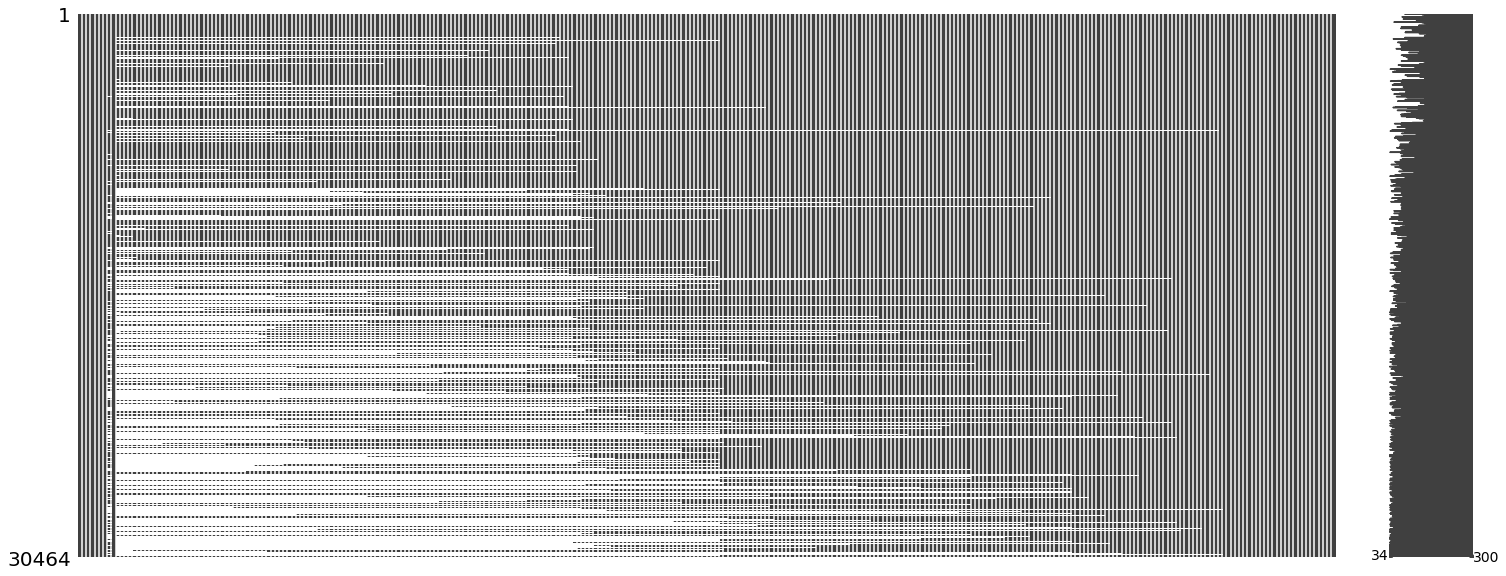

In [3]:
#Check for missing values as some appear in the print out
mno.matrix(zillowdf)
# the data appears to be more sparse at the beginning

The next two blocks organize the data from so the Zip codes are columns.

Following this step I interpolated the values backwards in time to fill in the missing values rather than sampling down.

In [4]:
#Make the dataset log
zillowdf = zillowdf.melt(id_vars=['RegionType','RegionID','RegionName','City','State','StateName','Metro','CountyName','SizeRank'],var_name="Period", value_name="MedianPrice")
zillowdf.head(7)

,RegionType,RegionID,RegionName,City,State,StateName,Metro,CountyName,SizeRank,Period,MedianPrice
0,Zip,61639,10025,New York,NY,NY,New York-Newark-Jersey City,New York County,0,1996-01-31,NaN
1,Zip,84654,60657,Chicago,IL,IL,Chicago-Naperville-Elgin,Cook County,1,1996-01-31,364892.0
2,Zip,61637,10023,New York,NY,NY,New York-Newark-Jersey City,New York County,2,1996-01-31,NaN
3,Zip,91982,77494,Katy,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1996-01-31,200475.0
4,Zip,84616,60614,Chicago,IL,IL,Chicago-Naperville-Elgin,Cook County,4,1996-01-31,546663.0
5,Zip,91940,77449,Katy,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,5,1996-01-31,97521.0
6,Zip,61616,10002,New York,NY,NY,New York-Newark-Jersey City,New York County,6,1996-01-31,NaN


In [6]:
medianReview = zillowdf.pivot_table(index='Period', columns='RegionName', values='MedianPrice').reset_index()
medianReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 30465 entries, Period to 99929
dtypes: float64(30464), object(1)
memory usage: 67.6+ MB


Now that the data frame has been melted down the next step was recast the data as time series so we can interpolate the missing values

In [7]:
#Converts the data to datetime
medianReview['Period']=medianReview['Period'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
#Indexes the records using the data
medianReview.set_index('Period', inplace=True)
#Interpolates the information based on the zip code working backwards in time
#This helps fill in the missing values
medianReview.interpolate(method='time', limit_direction='backward',axis=0, inplace=True)
#reset the index
medianReview = medianReview.reset_index()
#Melt the dataset back to long form
medianReview = medianReview.melt(id_vars='Period', var_name='ZipCode', value_name='MedianPrice')
#review the output
medianReview.head()

,Period,ZipCode,MedianPrice
0,1996-01-31,501,68555.0
1,1996-02-29,501,68555.0
2,1996-03-31,501,68555.0
3,1996-04-30,501,68555.0
4,1996-05-31,501,68555.0


Now that the data has been iterpolated, the next step was to merge it back in with the information about each of the Metro Regions. This allows us to answer the first question below

In [8]:
#Merge the interpolated data back with it's other attributes
zillowdf=zillowdf[['RegionName','Metro', 'State']]
zillowdf=zillowdf.drop_duplicates()
zillowdf = zillowdf.merge(medianReview, how='left', left_on='RegionName', right_on='ZipCode')
zillowdf.head()

,RegionName,Metro,State,Period,ZipCode,MedianPrice
0,10025,New York-Newark-Jersey City,NY,1996-01-31,10025,1513130.0
1,10025,New York-Newark-Jersey City,NY,1996-02-29,10025,1513130.0
2,10025,New York-Newark-Jersey City,NY,1996-03-31,10025,1513130.0
3,10025,New York-Newark-Jersey City,NY,1996-04-30,10025,1513130.0
4,10025,New York-Newark-Jersey City,NY,1996-05-31,10025,1513130.0


Many of the zip codes didn't look correct after converting toa  number, so I checked to see if the records were good. 00501 is the zip code for Holtsville New York per google. I decided to leave them in as the ispection shows this town in the New York city area matching the information from google.

In [9]:
zillowdf[zillowdf['ZipCode']==501] #Per Google this is Holtsville New York

,RegionName,Metro,State,Period,ZipCode,MedianPrice
8857749,501,New York-Newark-Jersey City,NY,1996-01-31,501,68555.0
8857750,501,New York-Newark-Jersey City,NY,1996-02-29,501,68555.0
8857751,501,New York-Newark-Jersey City,NY,1996-03-31,501,68555.0
8857752,501,New York-Newark-Jersey City,NY,1996-04-30,501,68555.0
8857753,501,New York-Newark-Jersey City,NY,1996-05-31,501,68555.0
...,...,...,...,...,...,...
8858035,501,New York-Newark-Jersey City,NY,2019-11-30,501,79265.0
8858036,501,New York-Newark-Jersey City,NY,2019-12-31,501,80266.0
8858037,501,New York-Newark-Jersey City,NY,2020-01-31,501,80878.0
8858038,501,New York-Newark-Jersey City,NY,2020-02-29,501,81419.0


# Initial Data Analysis Question:
1. What was the trend in Hot Springs Arkansas?
2. What was the trend in Little Rock Arkansas?
3. What was the trend in Fayetteville Arkansas?
4. What was the trend in Searcy Arkansas

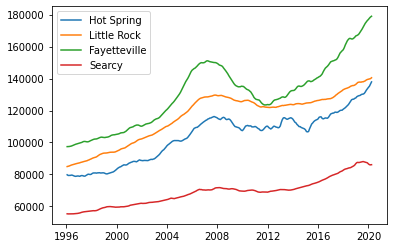

In [10]:
metros = zillowdf.groupby(['Period','Metro', 'State']).agg('mean').reset_index()
hotSpring = metros[(metros['State']=='AR')&(metros['Metro'].str.contains('Hot Springs')) ]
littleRock= metros[(metros['State']=='AR')&(metros['Metro'].str.contains('Little Rock')) ]
fayetteville = metros[(metros['State']=='AR')&(metros['Metro'].str.contains('Fayetteville')) ]
searcy = metros[(metros['State']=='AR')&(metros['Metro'].str.contains('Searcy')) ]
plt.plot(hotSpring['Period'], hotSpring['MedianPrice'], label = 'Hot Spring')
plt.plot(littleRock['Period'], littleRock['MedianPrice'], label = "Little Rock")
plt.plot(fayetteville['Period'], fayetteville['MedianPrice'], label = "Fayetteville")
plt.plot(searcy['Period'], searcy['MedianPrice'], label = "Searcy")
plt.legend()
plt.show()

As we can see from the chart above both Fayetteville and Hot Spring Arkansas have see quite large spikes in their housing prices in the last few years.

Fayetteville also suffered a sharp decline during the 2008 Financial Crisis but his since more than recovered where Hot Spring spent about 8 years from 2008 to 2016 with pretty much not increas in value.

Both Seacy and Little rock are start to see a trend up around 2016 as well but more moderate. Searcy based on teh data see a decline towards the end of 2019 but appears to be pointing upward as of 2020

# Model the Data

For this section designing and running in an Arima Model.

The first step was to create a test and training set. Since the ask was to produce prediction for the 2018 year, the data for 20 year swas used from 1997 to 2017 in the ARIMA model for training. A test set was held out to compare the results vs reality for 2018 with 12 prediction requested per zip code.

In [11]:
TrainingSet = zillowdf.set_index('Period').loc['1997-01-31':'2017-12-31'].reset_index().pivot_table(index = 'ZipCode', columns ='Period', values='MedianPrice')
TrainingSet.head()

Period,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,...,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31
ZipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
501,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,68555.0,...,63376.0,63671.0,64137.0,64552.0,65316.0,66142.0,66224.0,66203.0,66199.0,66511.0,66551.0,66392.0,66324.0,66054.0,66015.0,66132.0,66381.0,66553.0,66988.0,67635.0,68125.0,68739.0,68829.0,69039.0,68994.0,69428.0,69758.0,69991.0,69930.0,69698.0,69753.0,69657.0,69966.0,69898.0,70310.0,70566.0,70731.0,70874.0,70637.0,70635.0
601,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,86509.0,...,107562.0,107918.0,108189.0,108675.0,109327.0,109575.0,109751.0,109836.0,110059.0,110016.0,110234.0,110873.0,112179.0,113108.0,113751.0,113926.0,113907.0,114601.0,115740.0,117149.0,118956.0,120300.0,121285.0,121717.0,122036.0,122281.0,122768.0,123273.0,124605.0,125408.0,126331.0,126743.0,126939.0,127703.0,128610.0,128827.0,128485.0,128689.0,129269.0,130439.0
602,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,82787.0,...,79246.0,79190.0,78835.0,79557.0,80691.0,81753.0,82249.0,82352.0,82500.0,82908.0,83311.0,83756.0,83835.0,83795.0,83625.0,83675.0,83226.0,83440.0,83665.0,84312.0,85057.0,85591.0,85793.0,85656.0,85825.0,86671.0,87525.0,87892.0,88093.0,87730.0,87820.0,88317.0,88360.0,88466.0,88300.0,88739.0,89448.0,89978.0,90953.0,91225.0
604,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,59692.0,...,47822.0,48932.0,50515.0,51786.0,52826.0,53137.0,53234.0,53203.0,53792.0,54379.0,54589.0,54387.0,54385.0,54740.0,54682.0,54544.0,54737.0,55730.0,56546.0,57266.0,57573.0,57727.0,58148.0,58907.0,58940.0,59010.0,59134.0,59424.0,59095.0,58763.0,59210.0,59846.0,59786.0,60028.0,60150.0,60174.0,60096.0,59315.0,59148.0,59452.0
605,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,129397.0,...,114592.0,116769.0,11

In [77]:
TestSet =zillowdf.set_index('Period').loc['2018-01-31':'2018-12-31'].reset_index().pivot_table(index = 'ZipCode', columns ='Period', values='MedianPrice')
TestSet.head()

Period,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
ZipCode,,,,,,,,,,,,
501,70892.0,71435.0,72048.0,72204.0,72291.0,72030.0,72546.0,73167.0,74033.0,73884.0,74110.0,74041.0
601,130199.0,129986.0,129270.0,129509.0,129884.0,130274.0,130527.0,130689.0,131371.0,131779.0,133188.0,133978.0
602,91337.0,91205.0,90409.0,89591.0,88628.0,88355.0,88920.0,89629.0,90201.0,90160.0,90453.0,91410.0
604,60318.0,60456.0,60350.0,60189.0,60790.0,60686.0,60846.0,61088.0,61757.0,62872.0,63951.0,64730.0
605,144366.0,144236.0,144682.0,145496.0,146176.0,147756.0,148397.0,149856.0,150921.0,152012.0,151809.0,153149.0


## Autocorrelation and Partial Auto Correlation

These measures are use to train the model on how long it should go back in time to learn the moving average of the series and produce the results. The meausre can be controlled in the model. 

The charts says that utilizing auto regression of 20 and moveing average of 2 will follow the trend seen in the larger data set.

Best restuls were found in the model using a auto regression of 0.

In [14]:
housingAvg = TrainingSet.mean() # Collects the averages for caculation of autocorrelation and moving average

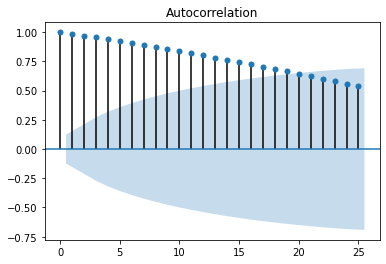

In [20]:
# Calculates and displays auto correlation
plot_acf(housingAvg)
plt.show()

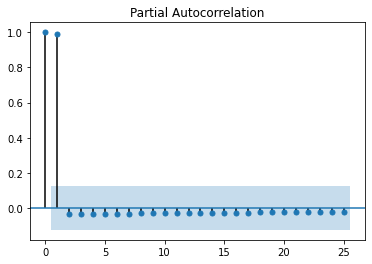

In [22]:
plot_pacf(housingAvg)
plt.show()

A Data Frame was created to store the values in the same order as a Zip Codes when the model is run below.

In [ ]:
prediction_2018 = pd.DataFrame(index=TestSet.index, columns=TestSet.columns)

The model below runs through each zip code row by row and creates a prediction for the next 12 month.

Attempted to get 2020 days but the model was taking too long to run so scraped it from the code. Despite the Autocorrelation that that 20 should preform best in the model it was found that setting 0 in the model for the moving average prodcued the best results.

The model takes about 2hours to run. so it was saved to CSV and reimported for further analysis.

In [ ]:
for i in TrainingSet.index:
  housing_train_series = TrainingSet.loc[i]
  try:
    model = arima(housing_train_series, order=(2, 0, 0))
    model_fit = model.fit()
  except:
    pass
  else:
    prediction_2018.loc[i] = model_fit.predict(start='2018-01', end='2018-12').apply(lambda x: round(x, 1))

In [ ]:
Prediction = prediction_2018.reset_index().melt(id_vars="ZipCode",var_name='Periods', value_name = 'MedianPrice')

In [ ]:
Predictions = Prediction.dropna()
Predictions.to_csv("predictions.csv")

In [78]:
# Reimport Predictions
Predictions = pd.read_csv('predictions.csv')
Predictions['Periods']=Predictions['Periods'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
Predictions

,Unnamed: 0,ZipCode,Periods,MedianPrice
0,1,601,2018-01-31,131341.4
1,2,602,2018-01-31,91377.3
2,4,605,2018-01-31,144899.1
3,6,610,2018-01-31,134199.5
4,7,611,2018-01-31,97656.1
...,...,...,...,...
327247,365561,99801,2018-12-31,409562.8
327248,365562,99824,2018-12-31,369886.2
327249,365564,99833,2018-12-31,239072.8
327250,365565,99835,2018-12-31,409506.6


Now that the predictions have been brought back into python, the next step is to compare them to the acutals from 2018.

Residual Mean Square Error is used to check the performance of the ARIMA Model, the closer to zero the value the better the model.

In [79]:
# Melt the Test into the same format as the Predictions, merge, and rename the columns for easier understanding
TestSet=TestSet.reset_index().melt(id_vars='ZipCode', var_name='Periods', value_name='MedianPrice')
TestSet = TestSet.merge(Predictions, how='inner',on=['ZipCode', 'Periods'])
TestSet.rename(columns={'MedianPrice_x':'ActualMedianPrice', 'MedianPrice_y':'PredictedMedianPrice'}, inplace=True)

In [80]:
# drops the records where there is no value predicted
TestSet = TestSet.dropna()

In [81]:
#calculates the mean square Error for each Zip Code
Actuals=TestSet.pivot_table(index='ZipCode', columns='Periods', values='ActualMedianPrice')
Preds = TestSet.pivot_table(index='ZipCode', columns='Periods', values='PredictedMedianPrice')
rmse = pd.DataFrame(index=Actuals.index, columns=['RMSE'])

for i in Actuals.index:
  rmse.loc[i] = mean_squared_error(Actuals.loc[i], Preds.loc[i], squared=False)

Now the it is cacluated the next step is visualize the information. The graph below shows the RMSE with the zip codes across the x axis and the squared errors along the Y Axis as we can see ther are some zip codes with extremely high RMSE and however the majority are quite low.

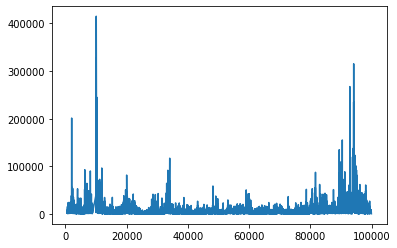

In [83]:
plt.plot(rmse.index, rmse['RMSE'])
plt.show()

The ZipCodes with Highes Mean Squared Erros appear to be mostly in New York those starting "10" and in the San Francisico Area.

As I live in New York city and have seen more recently huge changes in the house availability on the West Side where older brown stones have been replaced with luxury high rises, the model's univarity structure may not have enough information to correctly model this change in the amount of housing supply and the prices of these type of apartments

I suspect similar things can be seen in San Francisico which makes up the majority of the other zip codes seen below in the 10 where the model was under performing. The Area is going through a bit of housing crisis and the high demand has pushed prices ever higher

In [87]:
rmse.sort_values('RMSE',ascending=False).head(10)

,RMSE
ZipCode,
10128,415162
10014,327808
10065,320271
94123,315303
92868,267483
10282,245199
94115,234860
94129,215800
2112,201355


These are the top 10 zipcodes where the model preformed the best. As it turns out many of these are in the midwest and south easter united states. Where housing supply may be changing rapidly but similar stock is being built to meet with demand so the prices a likely staying stable giving the model ability to properly learn the patterns in these areas.

In [88]:
rmse.sort_values('RMSE',ascending=False).tail(10)

,RMSE
ZipCode,
39150,121.622
46750,119.649
44883,117.593
50441,117.168
76528,116.507
24112,110.569
27839,109.399
61832,104.172
14806,80.9122


## Best Returning Zip Codes

Lastly, based on the model Syracuse Realest Investment Trust wanted to know which 3 zip codes were predicted to perform the best. 

For this I took the predicted values in January 2018 and subtracted them from the predicted values in December 2018 and divided them by the starting price. This shows an expected return on investment of 28% in Darlington Missouri, a suburb of St Joseph Missiouri.

Following it is Curryville, Pennsylvania. A suburb of Altoon which 26.5% return in a year. This are of PA is a bit surprising because it really isn't located near any major centers that come to mind. Though is only 40 minutes south of State College, PA the main campus of Penn State is located here and may be that this area is the upcoming location for professionals choosing to stay in the area after graduation.

Lastly is North Las Vegas, Nevada an area that has been known for rapid growth. The model predicts 26% return in a year. This area has been growing rapidly as more people settle into the area. However; due to the growing water crisis in the Western part of the US, it likely would not be recommended to seek longer term invesetment here at the moment. Nearby areas of Utah has had 100% stoppage of new constrution due to the water shortages noted in the area.

In [106]:
BestReturningZips=TestSet[(TestSet['Periods']=='2018-01-31')|(TestSet['Periods']=='2018-12-31')]
BestReturningZips=BestReturningZips.pivot_table(index='ZipCode', columns='Periods', values='PredictedMedianPrice')
BestReturningZips['Return'] = (BestReturningZips['2018-12-31']-BestReturningZips['2018-01-31'])/BestReturningZips['2018-01-31']
BestReturningZips=BestReturningZips.sort_values('Return', ascending=False).head(3)
BestReturningZips

Periods,2018-01-31 00:00:00,2018-12-31 00:00:00,Return
ZipCode,,,
64438,101621.1,129987.2,0.279136
16631,136421.6,172573.8,0.265003
89030,154982.8,195415.9,0.260888


## Conclusion

Other data sources were considered for integration with the dataset to see about improving the model.

Bureau of labor statistics for one was collected. While the data set had month over month information on the jobs in various areas and portion of the working population employed for the 20 year period matching zillow, the information is stored at the Census defined Metropolitan and Micropolitan information. Since the request from Syracuse Realestat trust investment was at th zipcode level the data set was abandoned.

Similiarly the FBI also collects crime and population statistics that it makes publically available. The data only covered 10 years and was at the Metropolitan level as well and thus deemed not fit for purpose.

Over all the model appears to have produced generally good results with reasonable root mean squred error to go off the the advice noted for Missiour, Pennsylvania, and Nevada.